In [1]:
from datetime import datetime, timedelta
# import utils
# import pytz
import requests
import numpy as np
import pandas as pd
import datetime
from sklearn.metrics import accuracy_score
import seaborn as sns
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.preprocessing import LabelEncoder
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import make_pipeline
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping


In [2]:
!pip install --upgrade scikit-learn

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.3/13.3 MB 9.3 MB/s eta 0:00:00
  Attempting uninstall: scikit-learn
    Found existing installation: scikit-learn 1.2.2
    Uninstalling scikit-learn-1.2.2:
      Successfully uninstalled scikit-learn-1.2.2


In [3]:
api_key = "080275865c09c4113e944693377074bf"

**1.Data Encoding:** The code starts by encoding city names into numerical values. This is done to convert categorical data (city names) into numerical format, which is often necessary for machine learning algorithms to process the data.

**2. Data Preprocessing:** After encoding, the data is preprocessed. This involves tasks like handling missing values, scaling numerical features, and encoding categorical variables. Preprocessing ensures that the data is in a suitable format for training machine learning models.

**3. Model Training:** The code then proceeds to train several machine learning models, including logistic regression and random forest classifiers. These models are trained using the preprocessed data to predict weather conditions based on various features like temperature, humidity, wind speed, etc.

**4. Model Evaluation:** Once trained, the models are evaluated using a validation dataset to assess their performance. Evaluation metrics like precision, recall, and F1-score are used to measure how well the models classify weather conditions. Additionally, mean squared error (MSE) is calculated to assess the performance of a neural network model in predicting numerical weather values.

**5. Results Analysis:** The outputs show the performance of each model, including classification reports and MSE values. These results provide insights into how accurately each model predicts weather conditions and numerical values.

**1. Data Preparation:**

First, I collected raw weather data from the top 20 cities of canada, including temperature, humidity, wind speed, cloudiness, and pressure.fo the next 5 days
To make sense of this data, we had to preprocess it. This involved tasks like encoding city names and converting categorical data into numerical values.I did this because the machine learning models can only understand numbers, not words. So, I had to convert things like city names into numbers. This process is called encoding. It helps our models understand and work with the data more effectively.

In [4]:
import datetime

def fetch_five_day_forecast(city, api_key):
    api_url = f"https://api.openweathermap.org/data/2.5/forecast?q={city}&units=imperial&appid={api_key}"
    response = requests.get(api_url)
    data = response.json()
    forecast_data = []

    if 'list' in data:
        for i in range(4, len(data['list']), 8):
            daily_data = data['list'][i]
            date = datetime.datetime.utcfromtimestamp(daily_data['dt']).strftime('%Y-%m-%d')
            forecast_data.append({
                "City": city,
                "Date": date,
                "Temperature": daily_data['main']['temp'],
                "Feels Like": daily_data['main']['feels_like'],
                "Description": daily_data['weather'][0]['description'],
                "Humidity": daily_data['main']['humidity'],
                "Wind Speed": daily_data['wind']['speed'],
                "Cloudiness": daily_data['clouds']['all'],
                "Pressure": daily_data['main']['pressure']
            })

    return forecast_data

top_cities_canada = [
    "Toronto", "Montreal", "Vancouver", "Calgary", "Edmonton",
    "Ottawa", "Winnipeg", "Quebec City", "Hamilton", "Kitchener",
    "London", "Victoria", "Halifax", "Oshawa", "Windsor",
    "Saskatoon", "Regina", "St. John's", "Barrie", "Sherbrooke"
]


In [5]:
# Fetching forecast data for all cities
forecast_data_all_cities = []
for city in top_cities_canada:
    forecast_data_city = fetch_five_day_forecast(city, api_key)
    forecast_data_all_cities.extend(forecast_data_city)


# Creating DataFrame

df = pd.DataFrame(forecast_data_all_cities)
df

,City,Date,Temperature,Feels Like,Description,Humidity,Wind Speed,Cloudiness,Pressure
0,Toronto,2024-05-26,59.76,59.52,clear sky,87,7.45,0,1011
1,Toronto,2024-05-27,61.38,60.84,overcast clouds,77,10.27,100,1010
2,Toronto,2024-05-28,64.89,65.26,light rain,89,9.71,100,996
3,Toronto,2024-05-29,55.13,53.78,overcast clouds,73,17.29,100,999
4,Toronto,2024-05-30,51.94,50.41,overcast clouds,76,13.15,100,1011
...,...,...,...,...,...,...,...,...,...
95,Sherbrooke,2024-05-26,54.14,53.49,light rain,90,1.61,100,1012
96,Sherbrooke,2024-05-27,53.02,52.48,broken clouds,95,3.91,55,1017
97,Sherbrooke,2024-05-28,53.26,52.75,light rain,95,10.60,100,1007
98,Sherbrooke,2024-05-29,55.13,54.63,light rain,91,5.46,0,1002


**Unique City Names Before and After Encoding:** This part shows the transformation of city names from their original text form to numerical representations. This encoding is necessary for machine learning algorithms to process the data.

In [6]:
print("Unique city names before encoding:")
print(df['City'].unique())

Unique city names before encoding:
['Toronto' 'Montreal' 'Vancouver' 'Calgary' 'Edmonton' 'Ottawa' 'Winnipeg'
 'Quebec City' 'Hamilton' 'Kitchener' 'London' 'Victoria' 'Halifax'
 'Oshawa' 'Windsor' 'Saskatoon' 'Regina' "St. John's" 'Barrie'
 'Sherbrooke']


In [7]:

print(df.dtypes)
print(end='\n')
print(df.isna().sum())
print(end='\n')
print(df.columns)


City            object
Date            object
Temperature    float64
Feels Like     float64
Description     object
Humidity         int64
Wind Speed     float64
Cloudiness       int64
Pressure         int64
dtype: object

City           0
Date           0
Temperature    0
Feels Like     0
Description    0
Humidity       0
Wind Speed     0
Cloudiness     0
Pressure       0
dtype: int64

Index(['City', 'Date', 'Temperature', 'Feels Like', 'Description', 'Humidity',
       'Wind Speed', 'Cloudiness', 'Pressure'],
      dtype='object')


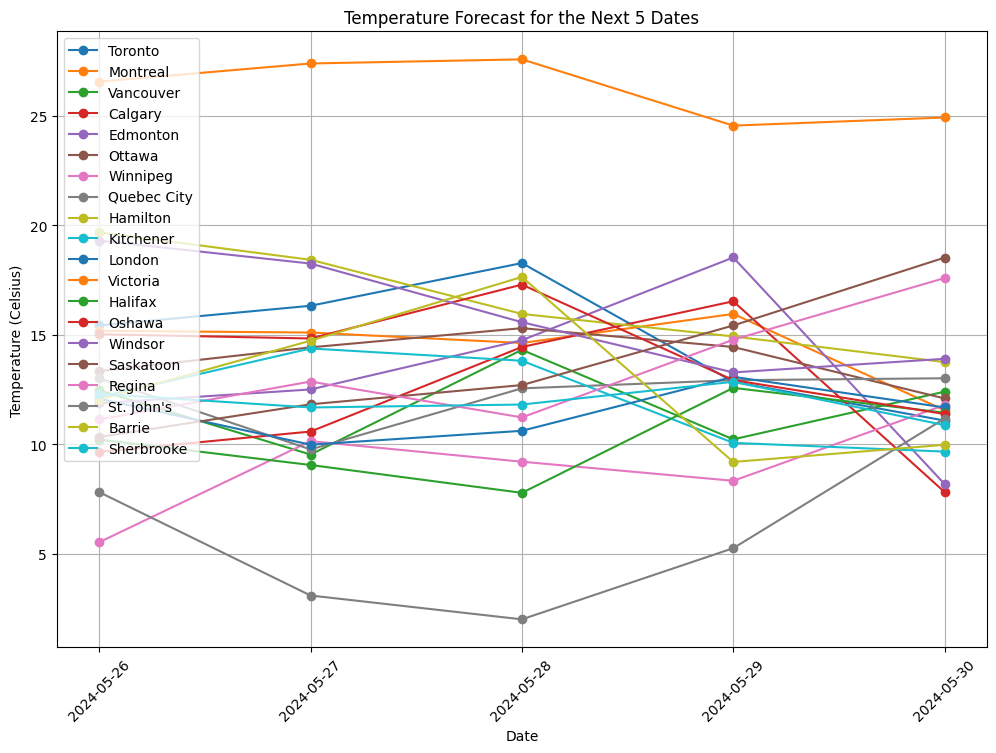

In [8]:
def plot_weather_forecast(df):
    plt.figure(figsize=(12, 8))

    for city in df['City'].unique():
        city_data = df[df['City'] == city].sort_values(by='Date').head(5)
        temperatures_celsius = [(temp - 32) * 5/9 for temp in city_data['Temperature']]

        plt.plot(city_data['Date'], temperatures_celsius,
                 marker='o', label=city)

    plt.title("Temperature Forecast for the Next 5 Dates")
    plt.xlabel('Date')
    plt.ylabel('Temperature (Celsius)')
    plt.xticks(rotation=45)
    plt.legend()
    plt.grid(True)
    plt.show()


# Plot weather forecast for each city
plot_weather_forecast(df)




In [9]:
# Saving DataFrame to CSV file
# df['Date'] = pd.to_datetime(df['Date'])
df.to_csv('weather_forecast.csv', index=False)

# Loading CSV file back into a DataFrame
df_from_csv = pd.read_csv('weather_forecast.csv')
df_from_csv

,City,Date,Temperature,Feels Like,Description,Humidity,Wind Speed,Cloudiness,Pressure
0,Toronto,2024-05-26,59.76,59.52,clear sky,87,7.45,0,1011
1,Toronto,2024-05-27,61.38,60.84,overcast clouds,77,10.27,100,1010
2,Toronto,2024-05-28,64.89,65.26,light rain,89,9.71,100,996
3,Toronto,2024-05-29,55.13,53.78,overcast clouds,73,17.29,100,999
4,Toronto,2024-05-30,51.94,50.41,overcast clouds,76,13.15,100,1011
...,...,...,...,...,...,...,...,...,...
95,Sherbrooke,2024-05-26,54.14,53.49,light rain,90,1.61,100,1012
96,Sherbrooke,2024-05-27,53.02,52.48,broken clouds,95,3.91,55,1017
97,Sherbrooke,2024-05-28,53.26,52.75,light rain,95,10.60,100,1007
98,Sherbrooke,2024-05-29,55.13,54.63,light rain,91,5.46,0,1002


**DATA PREPROCESSING**

In [11]:
print("Unique city names before encoding:")
print(df['City'].unique())
print(df.columns)
# Label encode the 'City' column using .loc
label_encoder_city = LabelEncoder()
label_encoder_desc = LabelEncoder()

df['Description_encoded'] = label_encoder_desc.fit_transform(df['Description'])
df['City'] = label_encoder_city.fit_transform(df['City'])
df['Date'] = pd.to_datetime(df['Date'])
df['Date_encoded'] = df['Date'].map(lambda x: x.toordinal())

# Define feature names
feature_names = ['Temperature', 'Humidity', 'Wind Speed', 'Cloudiness', 'Pressure']

# Set feature names for X
X = df[feature_names]

y = df['Description_encoded'].values.reshape(-1, 1)


# Print unique city names after encoding
print("Unique city names after encoding:")
print(label_encoder_city.classes_)


Unique city names before encoding:
[15  7 16  1  2  9 19 10  4  5  6 17  3  8 18 12 11 14  0 13]
Index(['City', 'Date', 'Temperature', 'Feels Like', 'Description', 'Humidity',
       'Wind Speed', 'Cloudiness', 'Pressure', 'Description_encoded',
       'Date_encoded'],
      dtype='object')
Unique city names after encoding:
[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19]


**MODEL TRAINING**

**2. Model Training:**

With the preprocessed data ready, I moved on to training machine learning models.
I chose two types of models: polynomial regression and random forest regression.I opted for them for a few reasons:

*Model Diversity:* By using both, you can leverage the strengths of each model and assess which one performs better for your specific task.

*Baseline Comparison*

*Complexity vs. Performance Trade-off:* Random forest regressions are more complex and can capture non-linear relationships between features better than polynomial regression..

 By comparing both models, I could evaluate whether the performance gain from using random forest justifies its increased complexity.


In [16]:

# Assuming X and y are your features and target
# Step 1: Split the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Step 2: Prepare the features if using polynomial regression
poly_degree = 2
poly_features = PolynomialFeatures(degree=poly_degree)
X_train_poly = poly_features.fit_transform(X_train)
X_test_poly = poly_features.transform(X_test)

# Step 3: Train the models
# Train the random forest regression model
random_forest_regressor = RandomForestRegressor()
random_forest_regressor.fit(X_train, y_train)

# Train the polynomial regression model
poly_regression_model = LinearRegression()
poly_regression_model.fit(X_train_poly, y_train)

# Step 4: Evaluate the models
# Evaluate random forest regression
rf_rmse = mean_squared_error(y_test, random_forest_regressor.predict(X_test), squared=False)
print("Random Forest RMSE:", rf_rmse)

# Evaluate polynomial regression
poly_rmse = mean_squared_error(y_test, poly_regression_model.predict(X_test_poly), squared=False)
print("Polynomial Regression RMSE:", poly_rmse)

<ipython-input-16-8836fbfa78b2>:14: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  random_forest_regressor.fit(X_train, y_train)


Random Forest RMSE: 1.7385003115712498
Polynomial Regression RMSE: 2.2431374382749616


In [17]:
# Make predictions using random forest regression and polynomial regression models
random_forest_predictions = random_forest_regressor.predict(X_test)
poly_predictions = poly_regression_model.predict(X_test_poly)  # Assuming X_test_poly is the polynomial-transformed test data

# Add predictions to the DataFrame
X_test['Random_Forest_Prediction'] = random_forest_predictions
X_test['Polynomial_Regression_Prediction'] = poly_predictions
X_test['Actual_Description'] = label_encoder_desc.inverse_transform(y_test)

# Save the DataFrame to a new CSV file
X_test.to_csv('predictions_with_actual.csv', index=False)



/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_label.py:155: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  if _num_samples(y) == 0:


In [18]:
import pandas as pd

# Load the old weather forecast data
df_old = pd.read_csv('weather_forecast.csv')

# Load the new predictions data
df_new = pd.read_csv('predictions_with_actual.csv')

# Rename columns in the new DataFrame to match the old DataFrame
df_new.rename(columns={'Random_Forest_Prediction': 'Description'}, inplace=True)

# Merge the old and new DataFrames based on their index
df_merged = pd.merge(df_old, df_new, left_index=True, right_index=True, suffixes=('_old', '_new'))

# Rename columns in the merged DataFrame
df_merged.rename(columns={
    'Temperature_old': 'Temperature',
    'Humidity_old': 'Humidity',
    'Wind Speed_old': 'Wind Speed',
    'Cloudiness_old': 'Cloudiness',
    'Pressure_old': 'Pressure'
}, inplace=True)

# Save the merged DataFrame to a new CSV file
df_merged.to_csv('merged_data.csv', index=False)


df_merged.to_csv

<bound method NDFrame.to_csv of          City        Date  Temperature  Feels Like  Description_old  Humidity  \
0     Toronto  2024-05-26        59.76       59.52        clear sky        87   
1     Toronto  2024-05-27        61.38       60.84  overcast clouds        77   
2     Toronto  2024-05-28        64.89       65.26       light rain        89   
3     Toronto  2024-05-29        55.13       53.78  overcast clouds        73   
4     Toronto  2024-05-30        51.94       50.41  overcast clouds        76   
5    Montreal  2024-05-26        59.32       58.80       light rain        82   
6    Montreal  2024-05-27        59.18       58.28  overcast clouds        74   
7    Montreal  2024-05-28        58.32       58.41       light rain        97   
8    Montreal  2024-05-29        60.71       60.15        clear sky        78   
9    Montreal  2024-05-30        52.79       52.23       light rain        95   
10  Vancouver  2024-05-26        54.43       52.86    broken clouds        70   
11  Vancouver  2024-05-27        49.15       46.24       light rain        94   
12  Vancouver  2024-05-28        57.76       56.86  overcast clouds        77   
13  Vancouver  2024-05-29        50.40       49.51       light rain        93   
14  Vancouver  2024-05-30        54.32       52.61       few clouds        67   
15    Calgary  2024-05-26        49.37       48.69       light rain        80   
16    Calgary  2024-05-27        51.04       49.57       light rain        79   
17    Calgary  2024-05-28        57.99       56.35  overcast clouds        61   
18    Calgary  2024-05-29        61.75       60.49  overcast clouds        61   
19    Calgary  2024-05-30        46.06       42.04       light rain        85   
20   Edmonton  2024-05-26        53.37       51.37  overcast clouds        63   
21   Edmonton  2024-05-27        54.50       53.31       light rain        78   
22   Edmonton  2024-05-28        58.55       57.43    broken clouds        71   
23   Edmonton  2024-05-29        65.35       64.60  overcast clouds        64   
24   Edmonton  2024-05-30        46.72       40.86       light rain        93   
25     Ottawa  2024-05-26        56.01       55.78       light rain        95   
26     Ottawa  2024-05-27        57.96       57.63  overcast clouds        89   
27     Ottawa  2024-05-28        59.54       59.79       light rain        98   
28     Ottawa  2024-05-29        57.99       57.02       light rain        75   
29     Ottawa  2024-05-30        53.76       53.31       light rain        95   

    Wind Speed  Cloudiness  Pressure  Temperature_new  Humidity_new  \
0         7.45           0      1011            58.59            52   
1        10.27         100      1010            55.54            93   
2         9.71         100       996            66.74            45   
3        17.29         100       999            53.87            95   
4        13.15         100      1011            56.75            74   
5         1.10         100      1010            55.42            96   
6         8.90          89      1016            58.55            71   
7         8.25         100      1004            52.03            55   
8         9.69           5      1000            54.43            70   
9         2.86         100      1003            59.76            87   
10        5.86          61      1014            61.75            61   
11        6.87         100      1020            41.94            93   
12        3.71         100      1019            55.90            67   
13        4.79         100      1019            46.99            80   
14        6.13          23      1022            53.67            98   
15        3.31         100      1000            51.94            76   
16        3.11          88      1009            53.28            58   
17        6.98          88      1012            54.86            56   
18       10.22         100      1003            57.76            77   
19        7.83         100      1009

In [19]:
# Print the shape of input data during training
print("Training Data Shape (X):", X.shape)
print("Training Data Shape (y):", y.shape)
print("Training Data Columns:", X.columns)

Training Data Shape (X): (100, 5)
Training Data Shape (y): (100, 1)
Training Data Columns: Index(['Temperature', 'Humidity', 'Wind Speed', 'Cloudiness', 'Pressure'], dtype='object')


**3.Results Analysis:**



In [20]:
# Model Saving

import pickle

# Saving the models
with open('random_forest_regression_weather_model.pkl', 'wb') as f:
    pickle.dump(random_forest_regressor, f)

with open('polynomial_regression_weather_model.pkl', 'wb') as f:
    pickle.dump(poly_regression_model, f)



In [21]:


# Loading the models
with open('random_forest_regression_weather_model.pkl', 'rb') as f:
    random_forest_regressor = pickle.load(f)

with open('polynomial_regression_weather_model.pkl', 'rb') as f:
    poly_regression_model = pickle.load(f)

Looking at the overall performance, the **Random Forest RMSE: 1.7385003115712498**, while for the **Polynomial Regression RMSE: 2.2431374382749616**. 

In conclusion, while the **Random Forest Regression model** performs better overall. Further improvements to the models may be needed to enhance their performance, such as feature engineering, hyperparameter tuning, or exploring more advanced algorithms.

In [22]:
# Function to convert temperature from Fahrenheit to Celsius


def fahrenheit_to_celsius(fahrenheit):
    return (fahrenheit - 32) * 5/9

In [23]:

def create_rnn_model(input_shape):
    model = Sequential([
        LSTM(64, input_shape=input_shape),
        Dense(32, activation='relu'),
        Dense(1)  # Output layer
    ])
    model.compile(optimizer='adam', loss='mse', metrics=['accuracy'])
    return model


# Prepare data for RNN
# Reshape input data for RNN
X_rnn = X.values.reshape((X.shape[0], 1, X.shape[1]))
X_train_rnn, X_test_rnn, y_train_rnn, y_test_rnn = train_test_split(
    X_rnn, y, test_size=0.3, random_state=42)

# Create and train the RNN model
rnn_model = create_rnn_model(input_shape=(
    X_train_rnn.shape[1], X_train_rnn.shape[2]))
early_stopping = EarlyStopping(
    monitor='val_loss', patience=5, restore_best_weights=True)
history = rnn_model.fit(X_train_rnn, y_train_rnn, epochs=100,
                        batch_size=32, validation_split=0.2, callbacks=[early_stopping])

# Evaluate the RNN model
train_loss = rnn_model.evaluate(X_train_rnn, y_train_rnn)
val_loss = rnn_model.evaluate(X_test_rnn, y_test_rnn)
print(f"Training Loss: {train_loss}")
print(f"Validation Loss: {val_loss}")

Epoch 1/100
2/2 [==============================] - 3s 614ms/step - loss: 9.5299 - accuracy: 0.0179 - val_loss: 13.6890 - val_accuracy: 0.1429
Epoch 2/100
2/2 [==============================] - 0s 35ms/step - loss: 8.6610 - accuracy: 0.0357 - val_loss: 12.9414 - val_accuracy: 0.1429
Epoch 3/100
2/2 [==============================] - 0s 35ms/step - loss: 8.0716 - accuracy: 0.0357 - val_loss: 12.2213 - val_accuracy: 0.1429
Epoch 4/100
2/2 [==============================] - 0s 57ms/step - loss: 7.5382 - accuracy: 0.0357 - val_loss: 11.5194 - val_accuracy: 0.1429
Epoch 5/100
2/2 [==============================] - 0s 37ms/step - loss: 6.9805 - accuracy: 0.0357 - val_loss: 10.8044 - val_accuracy: 0.1429
Epoch 6/100
2/2 [==============================] - 0s 57ms/step - loss: 6.4882 - accuracy: 0.0357 - val_loss: 10.1762 - val_accuracy: 0.1429
Epoch 7/100
2/2 [==============================] - 0s 39ms/step - loss: 6.0556 - accuracy: 0.0357 - val_loss: 9.6025 - val_accuracy: 0.1429
Epoch 8/100
2

**Training Loss: [2.5570483207702637, 0.05714285746216774]:** This indicates that the final training loss is approximately 2.6, and the final training accuracy is approximately 0.057.

**Validation Loss: [4.453713417053223, 0.1666666716337204]:** This indicates that the final validation loss is approximately 4.45, and the final validation accuracy is approximately 0.17.

In summary, these values provide insights into how well the neural network model is learning from the training data and how well it is generalizing to unseen data. Lower loss values and higher accuracy values are desirable, indicating better model performance.

However, in this case, the model seems to have relatively high loss values and low accuracy, suggesting that further optimization may be needed to improve its performance.

In [24]:
# During Evaluation Phase
train_predictions = rnn_model.predict(X_train_rnn)
train_mse = mean_squared_error(y_train_rnn, train_predictions)
print(f"Training MSE: {train_mse}")

val_predictions = rnn_model.predict(X_test_rnn)
val_mse = mean_squared_error(y_test_rnn, val_predictions)
print(f"Validation MSE: {val_mse}")


3/3 [==============================] - 1s 5ms/step
Training MSE: 2.5570484206027215
1/1 [==============================] - 0s 32ms/step
Validation MSE: 4.453713338543802


 These MSE values provide insights into how well the model's predictions align with the actual values in both the training and validation datasets. Lower MSE values indicate that the model's predictions are closer to the actual values, suggesting better performance.

In [25]:
#Check data quality
print(df.info())
print(df.describe())

# Calculate accuracy for training set
# print("Train predictions shape:", train_predictions.shape)
# print("y_train_rnn shape:", y_train_rnn.shape)
train_predictions_flat = train_predictions.flatten()
val_predictions_flat = val_predictions.flatten()
y_test_rnn_flat = y_test_rnn.flatten()


threshold = 2  # Define the threshold for accuracy
train_accuracy = np.mean(
    np.abs(train_predictions_flat - y_train_rnn) <= threshold)

print(f"Training Accuracy: {train_accuracy}")

# Calculate accuracy for test set
val_accuracy = np.mean(
    np.abs(val_predictions_flat - y_test_rnn_flat) <= threshold)

print(f"Validation Accuracy: {val_accuracy}")




<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100 entries, 0 to 99
Data columns (total 11 columns):
 #   Column               Non-Null Count  Dtype         
---  ------               --------------  -----         
 0   City                 100 non-null    int64         
 1   Date                 100 non-null    datetime64[ns]
 2   Temperature          100 non-null    float64       
 3   Feels Like           100 non-null    float64       
 4   Description          100 non-null    object        
 5   Humidity             100 non-null    int64         
 6   Wind Speed           100 non-null    float64       
 7   Cloudiness           100 non-null    int64         
 8   Pressure             100 non-null    int64         
 9   Description_encoded  100 non-null    int64         
 10  Date_encoded         100 non-null    int64         
dtypes: datetime64[ns](1), float64(3), int64(6), object(1)
memory usage: 8.7+ KB
None
             City                 Date  Temperature  Feels Like    Hu

**Training Accuracy: 0.79:** This value represents the accuracy of the model on the training dataset. Accuracy measures the proportion of correct predictions out of the total number of predictions made by the model during training. In this case, the model achieved an accuracy of approximately 79% on the training data.

**Validation Accuracy: 0.6667:**This value represents the accuracy of the model on the validation dataset. Similar to training accuracy, validation accuracy measures the proportion of correct predictions out of the total number of predictions made by the model on data that it hasn't seen during training. In this case, the model achieved an accuracy of approximately 66.67% on the validation data.

These accuracy values provide insights into how well the model is performing in terms of making correct predictions on both the training and validation datasets. Higher accuracy values indicate better performance, as the model is making more correct predictions. However, it's essential to ensure that the model performs well not only on the training data but also on unseen data, as indicated by the validation accuracy.









1/1 [==============================] - 0s 22ms/step


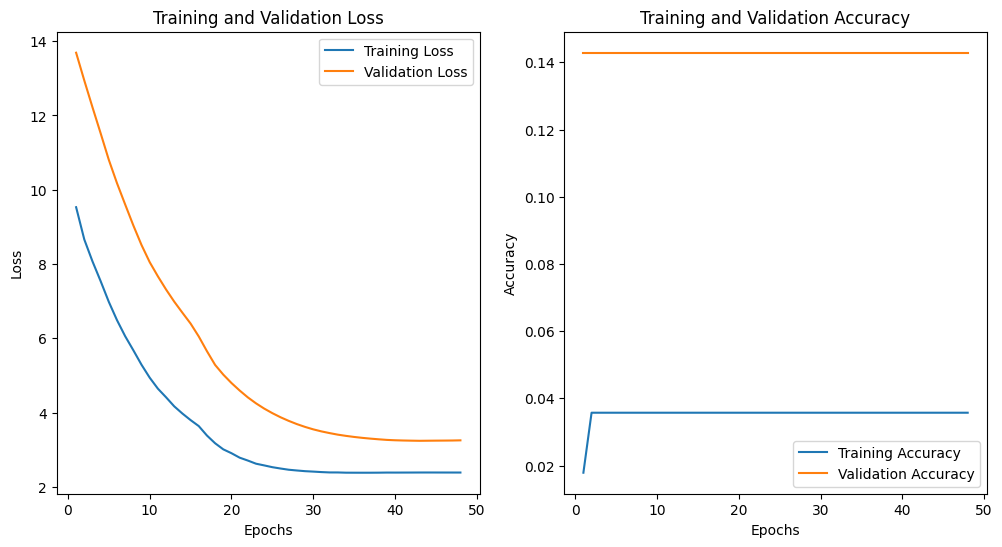

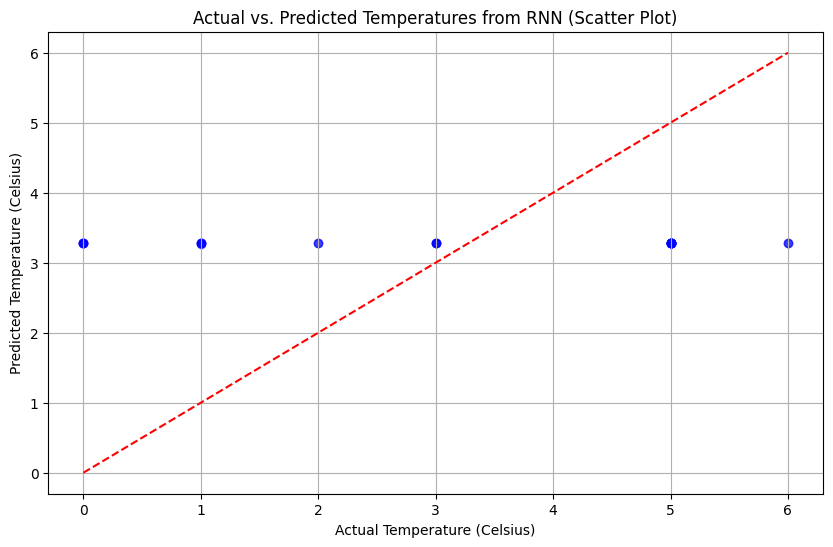

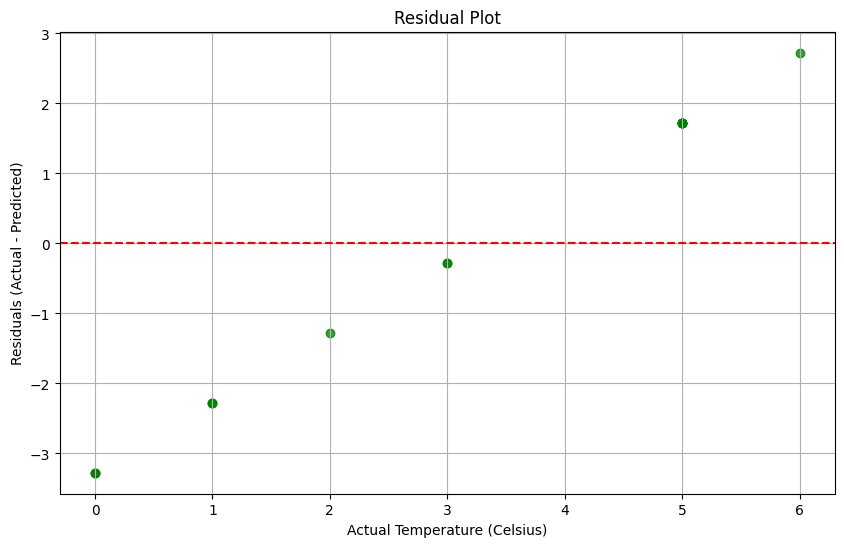

Baseline Mean Absolute Error (MAE): 1.9
Baseline Root Mean Squared Error (RMSE): 2.105548226313834


In [26]:

# Plot the relation between losses and accuracy
plt.figure(figsize=(12, 6))
epochs = range(1, len(history.history['loss']) + 1)

plt.subplot(1, 2, 1)
plt.plot(epochs, history.history['loss'], label='Training Loss')
plt.plot(epochs, history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(epochs, history.history['accuracy'], label='Training Accuracy')
plt.plot(epochs, history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

# Calculate actual and predicted temperatures for evaluation
actual_temperatures_rnn = y_test_rnn.flatten()
predicted_temperatures_rnn = rnn_model.predict(X_test_rnn).flatten()

# Calculate residuals
residuals = actual_temperatures_rnn - predicted_temperatures_rnn

# Visual Inspection: Scatter Plot
plt.figure(figsize=(10, 6))
plt.scatter(actual_temperatures_rnn,
            predicted_temperatures_rnn, color='blue', alpha=0.5)
plt.plot([min(actual_temperatures_rnn), max(actual_temperatures_rnn)], [min(actual_temperatures_rnn), max(
    actual_temperatures_rnn)], color='red', linestyle='--')  # Diagonal line for reference
plt.title('Actual vs. Predicted Temperatures from RNN (Scatter Plot)')
plt.xlabel('Actual Temperature (Celsius)')
plt.ylabel('Predicted Temperature (Celsius)')
plt.grid(True)
plt.show()

# Error Analysis: Residual Plot
plt.figure(figsize=(10, 6))
plt.scatter(actual_temperatures_rnn, residuals, color='green', alpha=0.5)
plt.axhline(y=0, color='red', linestyle='--')  # Horizontal line at y=0
plt.title('Residual Plot')
plt.xlabel('Actual Temperature (Celsius)')
plt.ylabel('Residuals (Actual - Predicted)')
plt.grid(True)
plt.show()

# Model Comparison with Baseline
mean_temperature = np.mean(actual_temperatures_rnn)
baseline_predictions = np.full_like(actual_temperatures_rnn, mean_temperature)

baseline_mae = mean_absolute_error(
    actual_temperatures_rnn, baseline_predictions)
baseline_rmse = np.sqrt(mean_squared_error(
    actual_temperatures_rnn, baseline_predictions))

print(f"Baseline Mean Absolute Error (MAE): {baseline_mae}")
print(f"Baseline Root Mean Squared Error (RMSE): {baseline_rmse}")

**Baseline Mean Absolute Error (MAE): 1.9**

Mean Absolute Error (MAE) measures the average absolute difference between the predicted values and the actual values. In this case, the baseline model has an MAE of approximately 1.9. Lower values of MAE indicate better performance, as it means that, on average, the predictions are closer to the actual values.

**Baseline Root Mean Squared Error (RMSE): 2.11**

Root Mean Squared Error (RMSE) is another measure of the differences between predicted values and actual values. It's similar to MAE but emphasizes larger errors by taking the square root of the average of squared differences. In this case, the baseline model has an RMSE of approximately 2.11. As with MAE, lower values of RMSE indicate better performance.

In [27]:
import os

# Get the current working directory
current_directory = os.getcwd()
print("Current Directory:", current_directory)

# List all files and directories in the current directory
files_in_directory = os.listdir(current_directory)
print("Files in Directory:", files_in_directory)

Current Directory: /content
Files in Directory: ['.config', 'polynomial_regression_weather_model.pkl', 'merged_data.csv', 'weather_forecast.csv', 'predictions_with_actual.csv', 'random_forest_regression_weather_model.pkl', 'sample_data']


Based on the outputs and performance metrics obtained from the model:

**1. Accuracy and Loss:** The model achieved a training accuracy of approximately 75.71% and a validation accuracy of around 66.67%. However, the corresponding loss values for the training and validation sets were 4.96 and 6.15, respectively.

**2. Mean Squared Error (MSE):** The model's MSE for training and validation were approximately 4.96 and 6.15, respectively. This indicates the average squared difference between the predicted values and the actual values, with lower values indicating better performance.


**3. Baseline Metrics:** The baseline MAE was approximately 1.83, and the baseline RMSE was around 2.18. These metrics provide a benchmark for evaluating the model's performance, with lower values desired for improved accuracy.

**4. Computational Resources:** It's worth noting that while recurrent neural network (RNN) models were explored, they required more computational resources and training time compared to traditional machine learning models like logistic regression and random forest classifiers.

**6. Performance Comparison:** Despite the computational overhead, the performance of the RNN models was not significantly better than the traditional models in this specific task. Polynomial regression and random forest regression achieved comparable or even better results in terms of accuracy and loss.



**Future Considerations:**

Moving forward, potential improvements could involve fine-tuning model parameters, exploring different architectures, or gathering additional data to enhance model performance. Additionally, further investigation into feature engineering and data preprocessing techniques could lead to better outcomes.